In [403]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn import metrics

In [404]:
def mostrarHistograma(imagen):
    histograma = cv2.calcHist([imagen], [0], None, [256], [0,256])
    plt.figure(figsize = (10,7))
    plt.plot(np.arange(len(histograma[:,0])), histograma[:,0])

def muestra(imagen):
    cv2.imshow('',imagen)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [405]:
def mostrarHistograma(imagen, ax=None, etiqueta=None):
    imagen = np.uint8(imagen)  # Asegurarse de que la imagen esté en formato uint8
    histograma = cv2.calcHist([imagen], [0], None, [256], [0, 256])
    #histograma = histograma / histograma.max()  # Normalizar el histograma para que no se sobrepasen los límites
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.plot(np.arange(256), histograma[:, 0],label=etiqueta)
    ax.set_xlim(0, 255)  # Asegurar que el eje X esté entre 0 y 255

In [406]:
def im_to_col(imagen, m, n):
    filas, columnas = imagen.shape
    a = m//2
    b = n//2
    imagen2 = np.zeros((m*n, filas*columnas))
    imagen = cv2.copyMakeBorder(imagen, a, a, b, b, cv2.BORDER_REPLICATE)
    aux = 0
    for i in range(a, filas+a):
        for j in range(b, columnas+b):
            imagen2[:, aux] = imagen[i-a:i+a+1, j-b:j+b+1].flatten()
            aux += 1
    return imagen2

In [407]:
def filtro_espacial(imagen, H):
    hfilas, hcolumnas = H.shape
    imagen2 = im_to_col(imagen,hfilas,hcolumnas)
    filas, columnas = imagen.shape
    for i in range(filas):
        for j in range(columnas):
            imagen[i,j] = np.sum(imagen2[:,i*columnas +j].reshape(H.shape) * H)
    return  imagen

In [408]:
def crea_imagen_final(imagen, labels, K):
    if len(imagen.shape) > 2:
        media_centros = np.zeros((K,3))
        for i in range(K):
            pix = imagen[labels == i]
            media_centros[i,:] = np.mean(pix,axis=0)
        nueva = media_centros[labels].reshape(imagen.shape)
        return nueva
    else:
        media_centros = np.zeros(K)
        for i in range(K):
            pix = imagen[labels == i]
            media_centros[i] = np.mean(pix,axis=0)
        nueva = media_centros[labels].reshape(imagen.shape)
        return nueva

In [409]:
def modificarImagen(imagen,n):
    imagen_modificada = cv2.resize(imagen, (n, n), interpolation=cv2.INTER_AREA)    
    return np.uint8(imagen_modificada)

In [410]:
from skimage.segmentation import slic

resolucion = 256

def prepro_rango_dinamico(nueva):
    #Ampliacion del rango dinamico
    nueva = np.float32(nueva)
    r1 = np.min(nueva)
    r2 = np.max(nueva)
    nueva = 255 * (nueva - r1) / (r2 - r1)
    return np.uint8(nueva)

def prepro_ecualizacion_histograma(nueva):
    #Ecualizacion del histograma
    num_pixels = nueva.size
    hp = cv2.calcHist([nueva], [0], None, [256], [0,256])/num_pixels
    hp = hp.cumsum()
    nueva = hp[np.uint8(nueva)] * 255
    return np.uint8(nueva)

def prepro_suavizado(nueva):
    #Suavizado
    H = np.ones((5,5))/25
    m,n = H.shape
    imagen_aux = im_to_col(nueva,m,n)
    filas, columnas = nueva.shape
    H = H.reshape(1,-1)
    nueva = H.dot(imagen_aux).reshape(-1,columnas)
    return np.uint8(nueva)

def prepro_super_pixeles(nueva, n=175):
    im_slic = slic(nueva,n_segments=n,channel_axis=None)
    imagen = crea_imagen_final(nueva, im_slic, n)
    return np.uint8(imagen)

def prepro_eliminar_fondo(imagen):
    # Aplicar un desenfoque para suavizar la imagen
    suavizada = cv2.GaussianBlur(imagen, (5, 5), 0)
    
    # Aplicar umbralización binaria para separar el objeto del fondo
    _, umbral = cv2.threshold(suavizada, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Encontrar los contornos del objeto
    contornos, _ = cv2.findContours(umbral, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Crear una máscara del contorno más grande (suponiendo que sea el objeto principal)
    mascara = np.zeros_like(imagen)
    if contornos:
        contorno_principal = max(contornos, key=cv2.contourArea)
        cv2.drawContours(mascara, [contorno_principal], -1, color=255, thickness=-1)
    
    # Aplicar la máscara a la imagen original
    imagen_sin_fondo = cv2.bitwise_and(imagen, imagen, mask=mascara)
    
    return np.uint8(imagen_sin_fondo * 255)

def preprocesamiento(imagen): # todo junto
    imagen2 = modificarImagen(imagen,resolucion)
    #imagen2 = prepro_rango_dinamico(imagen2)
    #imagen2 = prepro_ecualizacion_histograma(imagen2)
    #imagen2 = prepro_suavizado(imagen2)
    #imagen2 = prepro_super_pixeles(imagen2)
    imagen2 = prepro_eliminar_fondo(imagen2)
    return imagen2


# def preprocesamiento(imagen): # sin preprocesamiento
#     return imagen

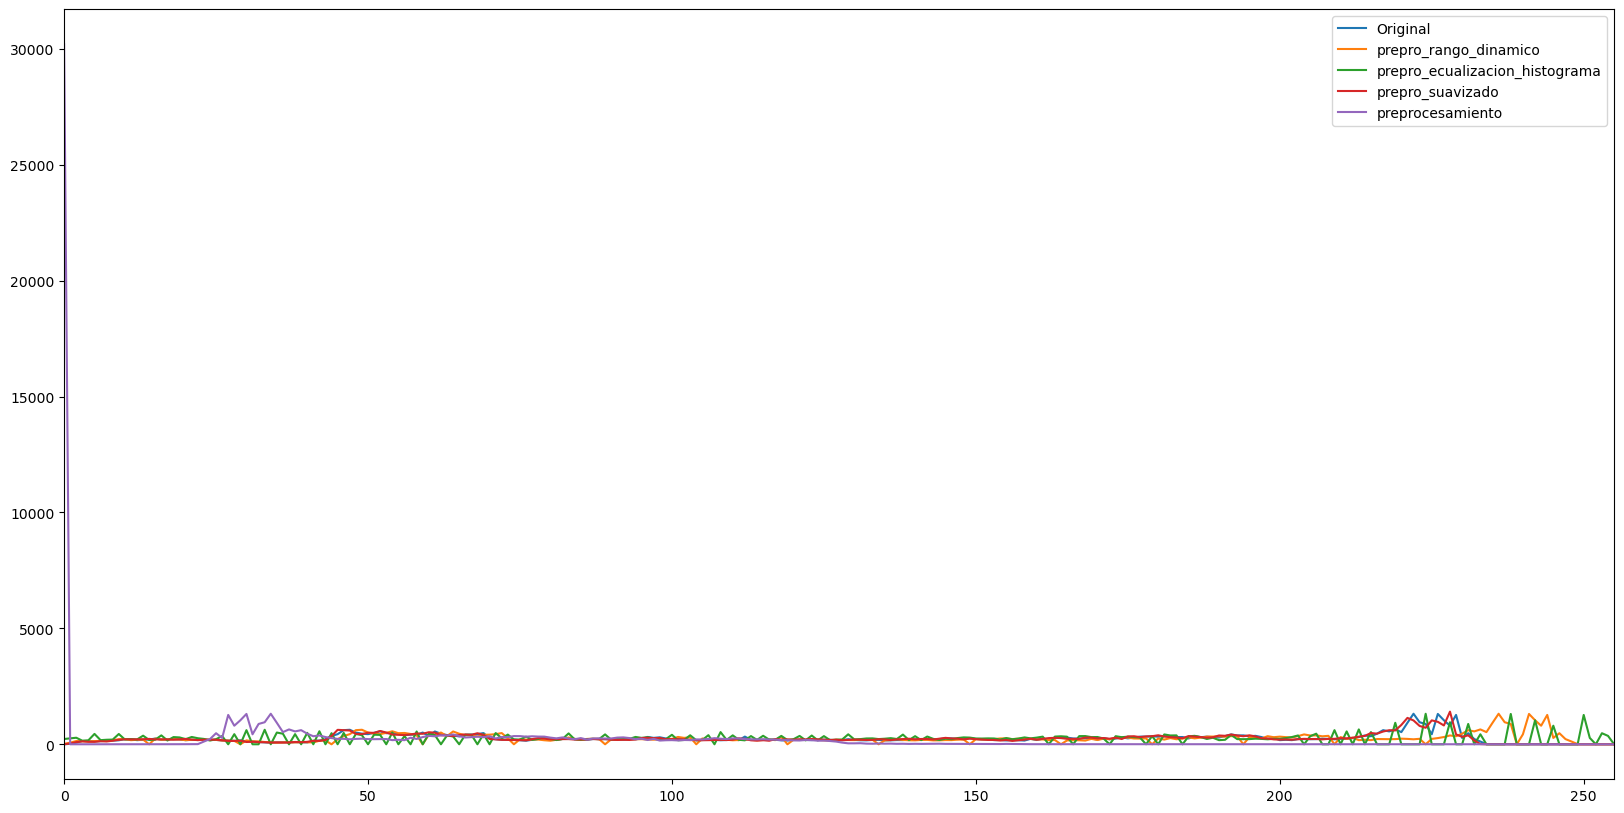

In [411]:
# Cargar la imagen
imagen = cv2.imread('dataset/cat_dog_100/train/cat/cat.0.jpg',0)

# Listado de técnicas de preprocesamiento
tecnicas_pre = [prepro_rango_dinamico,prepro_ecualizacion_histograma,prepro_suavizado,preprocesamiento] #,prepro_super_pixeles,prepro_ecualizacion_histograma,prepro_eliminar_fondo

# Crear la figura para los histogramas
fig, ax = plt.subplots(figsize=(20, 10))

# Mostrar histograma de la imagen original
mostrarHistograma(modificarImagen(imagen, resolucion), ax=ax, etiqueta="Original")
#cv2.imshow('Original', modificarImagen(imagen, resolucion))

# Aplicar las técnicas de preprocesamiento y mostrar los resultados
for i,tecnica in enumerate(tecnicas_pre):
    imagen2 = tecnica(modificarImagen(imagen,resolucion))
    mostrarHistograma(imagen2, ax=ax, etiqueta=tecnica.__name__)
    #cv2.imshow(tecnica.__name__, imagen2)

ax.legend()
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [412]:
muestra(preprocesamiento(imagen))

In [413]:
def gradiente(imagen):

    imagen_x = cv2.Sobel(imagen, cv2.CV_32F,1,0,ksize = 1)
    imagen_y = cv2.Sobel(imagen, cv2.CV_32F,0,1,ksize = 1)

    E = np.sqrt(np.power(imagen_x, 2) + np.power(imagen_y, 2))
    Phi = np.arctan2(imagen_y, imagen_x)
    Phi = np.rad2deg(Phi)

    return np.uint8(E), np.uint8(Phi)

In [414]:
def histogramasXceldas(num, E, phi):
    filas, columnas = imagen.shape
    histogramas = []
    for i in range(0, filas, num):
        for j in range(0, filas, num):
            celdaMag = E[i:i+num,j:j+num].flatten()
            celdaOri = phi[i:i+num,j:j+num].flatten()
            h = np.zeros(9)
            indices = celdaOri//(360//9)
            
            h = np.bincount(indices, weights=celdaMag, minlength=9)
            
            h = h/(np.sqrt(np.sum(h ** 2))+1e-6)
            histogramas.append(h)
    return histogramas
            

In [415]:
def extraccionCaracteristicas(imagen, num):
    imagen = np.float32(imagen)
    E, phi = gradiente(imagen)
    caracteristicas = np.concatenate(histogramasXceldas(num, E, phi))
    return caracteristicas

# def extraccionCaracteristicas(imagen, num, num_bins=8):
#     if len(imagen.shape) == 3:
#         print("La imagen debe estar en escala de grises.")

#     # Calcular el histograma de intensidad
#     hist = cv2.calcHist([imagen], [0], None, [num_bins], [0, 256])

#     # Normalizar el histograma
#     hist = hist.flatten()
#     hist /= (hist.sum() + 1e-6)
#     return hist

In [416]:
def entrenamiento():
    X_train = []
    y_train = []
    for i in range(100):
        imagen = cv2.imread('dataset/cat_dog_100/train/cat/cat.'+str(i)+'.jpg',0)
        imagen = preprocesamiento(imagen)
        caracteristicas = extraccionCaracteristicas(imagen, 16)
        X_train.append(caracteristicas)
        y_train.append(0)
    for i in range(100):
        imagen = cv2.imread('dataset/cat_dog_100/train/dog/dog.'+str(10000+i)+'.jpg',0)
        imagen = preprocesamiento(imagen)
        caracteristicas = extraccionCaracteristicas(imagen, 16)
        X_train.append(caracteristicas)
        y_train.append(1)

    print("empieza el entrenamiento del clasificador")
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    #clasificador = clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10, 10, 10, 10))
    clasificador = SVC(kernel='rbf', C=1.0, random_state=42)
    
    modelo = make_pipeline(StandardScaler(), clasificador)
    modelo.fit(X_train, y_train)

    return modelo

In [417]:
def evaluacion(modelo):
    X_test = []
    y_test = []
    imagenes = []
    for i in range(20):
        imagen = cv2.imread('dataset/cat_dog_100/test/cat/cat.'+str(10000+i)+'.jpg',0)
        imagen = preprocesamiento(imagen)
        imagenes.append(imagen)
        caracteristicas = extraccionCaracteristicas(imagen, 16)
        X_test.append(caracteristicas)
        y_test.append(0)
        
    for i in range(20):
        imagen = cv2.imread('dataset/cat_dog_100/test/dog/dog.'+str(10000+i)+'.jpg',0)
        imagen = preprocesamiento(imagen)
        imagenes.append(imagen)
        caracteristicas = extraccionCaracteristicas(imagen, 16)
        X_test.append(caracteristicas)
        y_test.append(1)

    print("empieza el entrenamiento del clasificador")  
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    y_pred = modelo.predict(X_test)

    acc = np.round(metrics.accuracy_score(y_pred,y_test)*100,2)

    return acc, imagenes, y_pred

    

In [ ]:
print("empieza entrenamiento")
modelo = entrenamiento()
print("empieza evaluacion")
acc, imagenes, predicciones = evaluacion(modelo)
print('El porcentaje de acierto del modelo es del {}%'.format(acc))

# for i,imagen in enumerate(imagenes):
#     if predicciones[i] == 0:
#         label = 'Clasificada como gato'
#     else:
#         label = 'Clasificada como perro'
        
#     cv2.imshow(label, imagen)
#     cv2.waitKey(0)

# cv2.destroyAllWindows()

empieza entrenamiento
empieza el entrenamiento del clasificador
empieza evaluacion
empieza el entrenamiento del clasificador
El porcentaje de acierto del modelo es del 90.0%
